# Single-Network Models

Consider a social network. A common question that we might have is how, exactly, we could describe the network in the simplest way possible. For instance, if we know nothing about the people, or how they might be connected in the social network, we might want to just say that a pair of people have a probability of being friends. On the other hand, if we know people within the social network are groups of students from different schools, we might want to say that people from the same school have a higher probability of being friends than people from different schools. The way we characterize the network in one of these (or other) ways is called the choice of the single-network model.


## Erd&ouml;s-R&eacute;nyi (ER)

The simplest random network model is the Erd&ouml;s R&eacute;nyi (ER) model<sup>1</sup>. Consider the social network example explained above. The simplest possible thing to do with our network would be to assume that a given pair of people within our network have the same chance of being friends as any other selected pair of people. The Erd&ouml;s R&eacute;nyi model formalizes this relatively simple model with a single parameter:

1. $p$: an edge existence probability parameter governing how edges are connected.  

In an Erd&ouml;s R&eacute;nyi network, each pair of nodes is connected with probability $p$, and therefore not connected with probability $1-p$. Further, no other properties of the network (including which vertices an edge is incident, other edges within the network, or any other factors) influence whether a pair of vertices are connected. Statistically, we write that for each edge $A_{ij}$, that $A_{ij}$ is sampled independently and identically from a $Bernoulli(p)$ distribution. The word "independent" means that edges in the network occurring or not occurring do not affect one another. The word "identical" means that every edge in the network has the same probability $p$ of being connected. If $\pmb A$ is the adjacency matrix for an ER network with probability $p$, we write that $\pmb A \sim ER_n(p)$.

In practice, the ER model seems like it might be a little too simple to be useful. Why would it ever be useful to think that the best we can do to describe our network is to say that connections exist with some probability? Does this miss a *lot* of useful questions we might want to answer? Fortunately, there are a number of ways in which the simplicity of the ER model is useful. Given a probability and a number of nodes, we can easily describe the properties we would expect to see in a network if that network were ER. For instance, we know what the degree distribution of an ER network should look like. We can reverse this idea, too: given a network we think might *not* be ER, we could check whether it's different in some way from a network which is ER. For instance, if we see a half of the nodes have a very high degree, and the rest of the nodes with a much lower degree, we can reasonably conclude the network might be more complex than can be described by the ER model. If this is the case, we might look for other, more complex, models that could describe our network. 


```{admonition}Working Out the Expected Degree in an Erd&ouml;s-R&eacute;nyi Network
Suppose that $(\mathcal V, \mathcal E)$ is the topology of an undirected network with loops and adjacency matrix $\pmb A$. The network has $n$ nodes $\mathcal V = (v_i)_{i = 1}^n$. Recall that the in an undirected, loopy network, node degree is $deg(v_i) = \sum_{j = 1}^n A_{ij}$. What is the expected degree of a given node $v_i$ if $\mathcal G$ were ER with probability parameter $p$?

To describe this, we will compute the expectated value of the degree $deg(v_i)$:
\begin{align*}
    \mathbb E\left[deg(v_i)\right] &= \mathbb E\left[\sum_{j = 1}^n A_{ij}\right] \\
    &= \sum_{j = 1}^n \mathbb E[A_{ij}]
\end{align*}
We use the *linearity of expectation* in the line above, which means that the expectation of a sum with a finite number of terms being summed over ($n$, in this case) is the sum of the expectations. Finally, by definition, all of the edges $A_{ij}$ have the same distribution: $Bernoulli(p)$. The expected value of a random quantity which takes a Bernoulli distribution is just the probability $p$! Therefore:
\begin{align*}
    \mathbb E\left[deg(v_i)\right] &= \sum_{j = 1}^n p = n\cdot p
\end{align*}
Since all of the $n$ terms being summed have the same expected value. This holds for *every* node $v_i$, which means that the expected degree of all nodes is an undirected ER network is the same.
```

The ER model is also useful for the development of new computational techniques to use on random networks. This is because even if the "best" model for a network is something much more complex, we can still calculate an edge probability $p$ for the network without needing any information but the adjacency matrix. Consider, for instance, a case where we design a new algorithm for a social network, and we want to know how much more RAM we might need as the social network grows. We might want to investigate how the algorithm scales to networks with different numbers of people and different connection probabilities that might be realistic as our social network expands in popularity. Examining how the algorithm operates on ER networks with different values of $n$ and $p$ might be helpful. This is an especially common approach when people deal with networks that are said to be *sparse*, or where $p$ is very small (and consequently, there aren't many edges).

In the next code block, we look to sample a single ER network with $50$ nodes and an edge probability $p$ of $0.3$:

<AxesSubplot:title={'center':'ER(50, 0.3) Simulation'}>

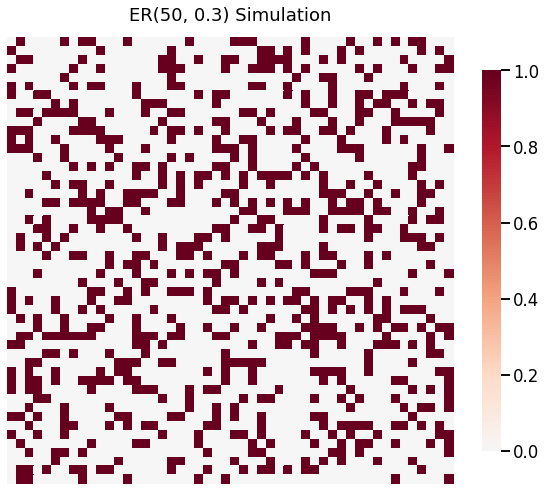

In [61]:
from graspologic.plot import heatmap
from graspologic.simulations import er_np

n = 50  # network with 50 vertices
ps = 0.3  # probability of an edge existing is .3

# sample a single adj. mtx from ER(50, .3)
As = er_np(n=n, p=ps, directed=True, loops=True)

# and plot it
heatmap(As, title="ER(50, 0.3) Simulation")

Above, we visualize the network using a heatmap. The dark red squares indicate that an edge exists between a pair of vertices, and white squares indicate that an edge does not exist between a pair of vertices.

If we already have a network, we might want to assume that the network is an ER network, and investigate the edge probability parameter. Next, we use graspologic to estimate the edge probability:

In [ ]:
from graspologic.models import EREstimator

# instantiate an ER Estimator which is directed with loops
er = EREstimator(directed=True, loops=True)
# fit an ER model to As
er.fit(As)
print(f"ER \"p\" parameter: {er.p_}")

As we can see, the edge probability parameter in a directed network with loops is just the average fraction of times $\pmb A$ has a value of $1$:

In [ ]:
print(f"Average edge weight: {As.mean()}")

Note that the $p$ parameter will be computed differently depending on whether the network is assumed to be directed or undirected, and loopy or hollow. Be careful to specify the appropriate model for the network you have.

Next, let's see what happens when we use a higher edge probability, like $p=0.7$:

In [ ]:
pl = 0.7  # network has an edge probability of 0.7

# sample a single adj. mtx from ER(50, 0.7)
Al = er_np(n=n, p=pl, directed=True, loops=True)

# and plot it
heatmap(Al, title="ER(50, 0.7) Simulation")

As the edge probability increases, the sampled adjacency matrix tends to indicate that there are more connections in the network. This is because there is a higher chance of an edge existing when $p$ is larger.

## Stochastic Block Model (SBM)

Consider the social network above. Using the ER model described above, we can only model the connections between a pair of people with a *fixed probability* that is the same for all pairs of students within the network. What would happen if we had additional information about students in our network that might influence the probability that they were friends? Consider, for instance, that we know which school each student attends. It seems fairly logical that if two students go to the same school, in general, they will probably have a higher probability of being friends than if they went to different schools. Unfortunately, using the ER model, there is nothing more complex we can do to reflect this fact. This is where the Stochastic Block Model, or SBM, comes into play. The Stochastic Block Model generalizes the ER model, and has the following two parameters:
1. $\vec \tau$: the node community assignment vector for each of the nodes in the network, and
2. $\pmb B$: the symmetric block matrix for each pair of communities.

With the SBM, we suppose that each node can be assigned to a group of nodes, called a **community**. Instead of describing all pairs of nodes by a fixed probability like with the ER model, in the SBM, we instead describe properties that hold for edges between *pairs of communities*. We write that $\vec \tau \in \{1, ..., K\}^n$, which means that $\vec \tau$ is an $n$-dimensional vector which takes one of $K$ possible values. In our social network example, for instance, this vector would reflect the fact that each of the $n$ students in our network could be attendees at one of $K$ possible schools. For a single node $i$ that is in community $\ell$, where $\ell \in \{1, ..., K\}$, we write that $\tau_i = \ell$. 

Next, let's discuss the matrix $\pmb B$, which is known as the **block matrix** of the SBM. We write down that $\pmb B \in [0, 1]^{K \times K}$, which means that the block matrix is a matrix with $K$ rows and $K$ columns. If we have a pair of nodes and know which of the $K$ communities each node is from, the block matrix tells us the probability that those two nodes are connected. This matrix $\pmb B$ is also symmetric, which means that if $b_{k, \ell} = p$ where $p$ is a probability, that $b_{\ell, k} = p$, too. 

Finally, let's think about how to write down the generative model for the SBM. Remember that $\vec \tau$ and $\pmb B$ are parameters, which means that when we fit a SBM, we know these ahead of time. Intuitionally what we want to reflect is, if we know that node $i$ is in community $\ell$ and node $j$ is in community $k$, that the $(\ell, k)$ entry of the block matrix is the probability that $i$ and $j$ are connected. Formally, we write this statement down by saying that $A_{ij}$ conditioned on $\tau_i = \ell$ and $\tau_j = k$ is sampled independently from a $Bernoulli(b_{\ell, k})$ distribution. Like the ER model, the edges are still independent, which means that edges occuring or not occuring do not have an impact on one another. Unlike above, we can no longer say that the $A_{ij}$s are identically distributed, since the probability $b_{\ell, k}$ depends on the communities that nodes $i$ and $j$ are assigned to. This means that if we were to look at a different pair of nodes, the probability that the two nodes are connected could be different, and therefore they would not share the same distribution.

We just covered a lot of intuition that will be critical for understanding many of the later models, so let's work through an example. Let's assume that we have $300$ students, and we know that each student goes to $1$ of $2$ possible schools. We don't really care too much about the ordering of the students for now, so let's just assume that the students are organized such that the first $150$ students all go to school $1$, and the second $150$ students all go to school $2$. Let's assume that the students from school $1$ are a little bit more closely knit than the students from school $2$, so we'll say that the probability of two students who both go to school $1$ being connected is $0.5$, and the probability of two students who both go to school $2$ being friends is $0.3$. Finally, let's assume that if one student goes to school $1$ and the other student goes to school $2$, that the probability that they are friends is $0.2$.

```{admonition} Thought Exercise

Before you read on, try to think to yourself about what the community assignment vector $\vec \tau$ and the block matrix $\pmb B$ look like.
```

Next, let's plot what $\vec \tau$ and $\pmb B$ look like:

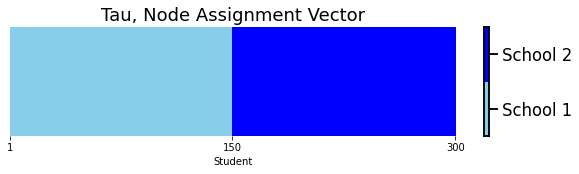

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

def plot_tau(tau, title="", xlab="Node"):
    cmap = matplotlib.colors.ListedColormap(["skyblue", 'blue'])
    fig, ax = plt.subplots(figsize=(10,2))
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap((tau - 1).reshape((1,tau.shape[0])), cmap=cmap,
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0.25, .75])
        cbar.set_ticklabels(['School 1', 'School 2'])
        ax.set(xlabel=xlab)
        ax.set_xticks([.5,149.5,299.5])
        ax.set_xticklabels(["1", "150", "300"])
        cbar.ax.set_frame_on(True)
    return

n = 300  # number of students

# tau is a column vector of 50 1s followed by 50 2s
tau = np.vstack((np.ones((int(n/2),1)), np.full((int(n/2),1), 2)))

plot_tau(tau, title="Tau, Node Assignment Vector",
        xlab="Student")

So as we can see, the first $50$ students are from school $1$, and the second $50$ students are from school $2$. Next, let's look at the block matrix $\pmb B$: 

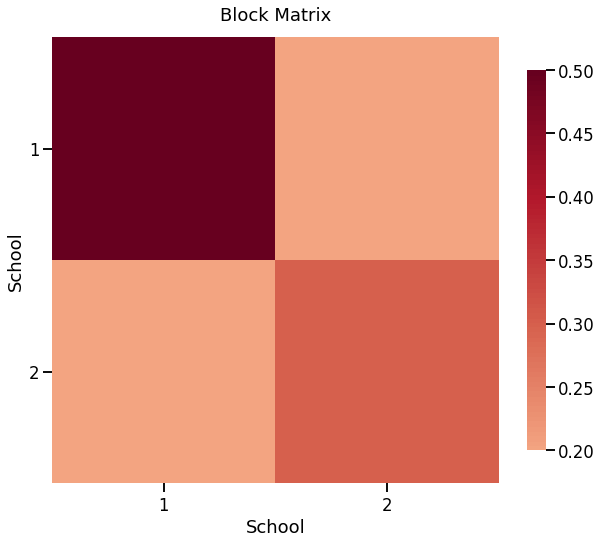

In [85]:
K = 2
B = np.zeros((K, K))
B[0,0] = .5
B[0,1] = B[1,0] = .2
B[1,1] = .3
ax = heatmap(B, title="Block Matrix")
ax.set_xlabel("School")
ax.set_ylabel("School")
ax.set_xticks([.5,1.5])
ax.set_xticklabels(["1", "2"])
ax.set_yticks([.5,1.5])
ax.set_yticklabels(["1","2"])
plt.show()

As we can see, the matrix $\pmb B$ is a symmetric block matrix. Finally, let's sample a single network from the SBM with parameters $\vec \tau$ and $\pmb B$:

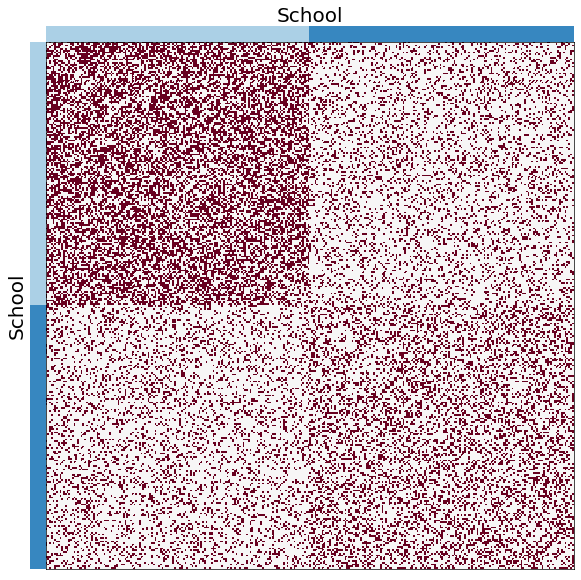

In [106]:
from graspologic.simulations import sbm
from graspologic.plot import adjplot
import pandas as pd

A = sbm(n=[int(n/2), int(n/2)], p=B)
meta = pd.DataFrame(
    data = {"School": tau.reshape((n)).astype(int)}
)

ax=adjplot(A, meta=meta, color="School", palette="Blues")

The above network shows students, ordered by the school they are in (school 1 and school 2, respectively). As we can see in the above network, people from school $1$ are more connected than people from school $2$, which we can see from the fact that there are more connections between people from school $1$ than from school $2$. Also, the connections between people from different schools appear to be a bit more sparse. The above heatmap can be described as **modular**: it has clearly delineated communities, which are the obvious "squares" in the above heatmap.

Something easy to mistake about the SBM is that the SBM will *not always* have the obvious modular structure defined above when we look at a heatmap. Rather, this modular structure is *only* made obvious because the students are ordered according to the school in which they are in. What do you think will happen if we look at the students in a random order? Do you think it will be obvious that the network will have a modular structure?

The answer is: *No!* Let's see what happens when we use an item, called a *permutation* of the nodes, to reorder the nodes from the network in a random order:

<ipython-input-110-be0831a05e70>:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax=adjplot(A[[vtx_perm]] [:,vtx_perm], meta=meta, color="School", palette="Blues")


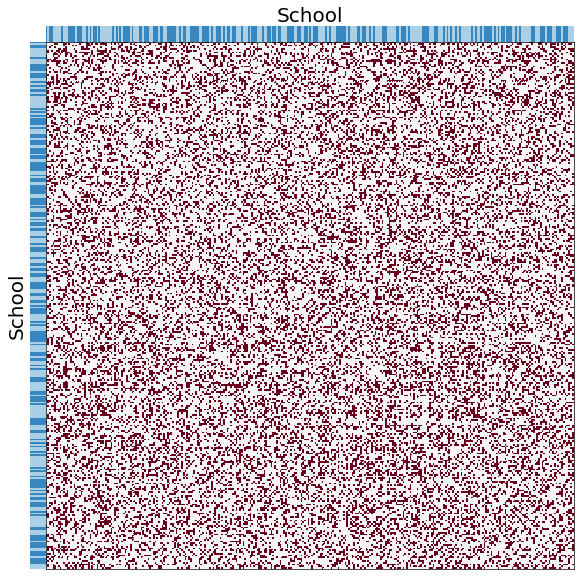

In [110]:
import numpy as np

# generate a permutation of the n vertices
vtx_perm = np.random.choice(n, size=n, replace=False)

meta = pd.DataFrame(
    data = {"School": tau[vtx_perm].reshape((n)).astype(int)}
)

# same adjacency matrix (up to reorder of the vertices)

ax=adjplot(A[[vtx_perm]] [:,vtx_perm], meta=meta, color="School", palette="Blues")

Notice that now, the students are *not* organized according to school. We can see this by looking at the school assignment vector, shown at the left and top, of the network. In this sense, it becomes quite difficult in practice to determine whether community structure exists simply by looking at a network, unless you are looking at a network in which the nodes are already arranged in an order which respects the community structure. To estimate community structure, we will later look at a number of approaches, including spectral embeddings.

## Random Dot Product Graph (RDPG)

## Generalized Random Dot Product Graph (GRDPG)

## Degree-Corrected Models

## Structured Independent Edge Model (SIEM)

## Inhomogeneous Erdos-Renyi (IER)

# References

[1] Erd&ouml;s P, R&eacute;nyi A. 1959. "On random graphs, I." Publ. Math. Debrecen 6:290–297.
